## Multi Atom Solutes

The first tutorial focused on solvation of Lithium, a single atom solute. While this is an illustrative example of solvation-analysis' capabilities, it does not capture the flexibility of `Solute`. Here, we analyze a system of water with dissolved isobutyric acid (IBA), a mulit-atom solute that hydrogen bonds with itself.


### System Setup

As usual, we must import our data and instantiate our `AtomGroups`.

In [20]:
import MDAnalysis as mda
from solvation_analysis import Solute

from solvation_analysis.tests.datafiles import iba_data, iba_dcd

u = mda.Universe(iba_data, iba_dcd)

iba = u.select_atoms("byres element C")
H2O = u.atoms - iba

The setup is much like before with two subtle differences, i) IBA has multiple atoms unlike one for Lithium ii) IBA can coordinate with itself, acting as both the solute *AND* solvent. To account for this, we create a Solute for each atom individually and then merge them into our full Solute. To do this, we use the `from_atoms` constructor which creates a solute for each unique atom in the IBA molecule.

In [21]:
solute = Solute.from_atoms(iba, {'IBA': iba, 'H2O': H2O}, solute_name='IBA_solute')

Let's visualize what we have with the `draw_molecule` method.

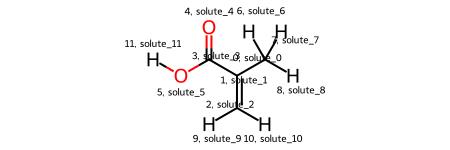

In [22]:
solute.draw_molecule('IBA_solute')

Because we didn't name any of the atom solutes, they default to 'solute_X' where X is their relative position in the IBA `Residue`. These names aren't very informative, so let's change them with the `rename_solutes` kwarg. In particular, let's rename the ketone O, alcohol O, and alcohol H.

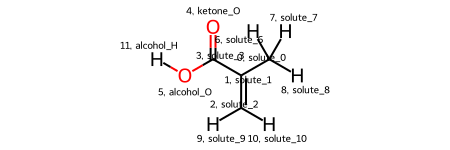

In [23]:
rename_solutes = {'solute_4': 'ketone_O', 'solute_5': 'alcohol_O', 'solute_11': 'alcohol_H'}

solute = Solute.from_atoms(
    iba,
    {'IBA': iba, 'H2O': H2O},
    solute_name='IBA_solute',
    rename_solutes=rename_solutes,
)

solute.draw_molecule('IBA_solute')

Much better! Now we can see that the functional groups of interest have been renamed. These names will propagate through all downstream analysis and make our future self much happier.

### The atom_solutes Dictionary

Note that we still have not called `run`, so no analysis has been performed. Before we do that, let's have a look at the `atom_solutes` property which contains the solutes for each atom.

In [24]:
solute.atom_solutes

{'solute_0': <solvation_analysis.solute.Solute at 0x7fcf1958cf70>,
 'solute_1': <solvation_analysis.solute.Solute at 0x7fcef844dbb0>,
 'solute_2': <solvation_analysis.solute.Solute at 0x7fcf1958c8e0>,
 'solute_3': <solvation_analysis.solute.Solute at 0x7fcf0030c700>,
 'ketone_O': <solvation_analysis.solute.Solute at 0x7fcef8a7c580>,
 'alcohol_O': <solvation_analysis.solute.Solute at 0x7fcef8a7c490>,
 'solute_6': <solvation_analysis.solute.Solute at 0x7fcf009f6430>,
 'solute_7': <solvation_analysis.solute.Solute at 0x7fcf28a27190>,
 'solute_8': <solvation_analysis.solute.Solute at 0x7fcf009e0d30>,
 'solute_9': <solvation_analysis.solute.Solute at 0x7fcf194c3490>,
 'solute_10': <solvation_analysis.solute.Solute at 0x7fcef8a9f490>,
 'alcohol_H': <solvation_analysis.solute.Solute at 0x7fcef8a9f640>}

We can see that it is a list of solutes for each atom, now with the nice names we've given. Let's take a closer look at the ketone.

In [25]:
ketone = solute.atom_solutes['ketone_O']
print('ketone solvents are:', ketone.solvents)
print('ketone solute name is:', ketone.solute_name)
print('ketone solute: atom_solutes', ketone.atom_solutes)
assert ketone is ketone.atom_solutes['ketone_O']

ketone solvents are: {'IBA': <AtomGroup with 4800 atoms>, 'H2O': <AtomGroup with 1200 atoms>}
ketone solute name is: ketone_O
ketone solute: atom_solutes {'ketone_O': <solvation_analysis.solute.Solute object at 0x7fcef8a7c580>}


We can see that the ketone_O solute has inherited it's name and solvents from the parent. In it's `atom_solutes` dictionary it contains only itself. The only difference between a single-atom solute and a multi-atom solute is whether they contain themself or other solutes in the `atom_solutes` dictionary.

A `Solute` with 12 atoms is a bit unwieldy, so let's make a smaller `Solute` from just the ketone and alcohol. We will use the `from_solute_list` constructor to create a new `Solute`.

In [26]:
solute_list = [solute.atom_solutes[name] for name in ['ketone_O', 'alcohol_O', 'alcohol_H']]

solute = solute.from_solute_list(
    solute_list,
    {'IBA': iba, 'H2O': H2O},
)

### Analysis of Multi Atom Solutes

Now we are ready to `run`! This works exactly as before.

In [27]:
solute.run()

Just like in the single atom case, we have coordination, pairing, and speciation information available.

In [28]:
print('Coordination Dictionary:', solute.coordination.coordination_numbers)
print('Pairing Dictionary:     ', solute.pairing.solvent_pairing)
solute.speciation.speciation_fraction.head(10)

Coordination Dictionary: {'H2O': 1.145, 'IBA': 0.7324999999999999}
Pairing Dictionary:      {'H2O': 0.6725000000000001, 'IBA': 0.525}


,H2O,IBA,count
0,1,0,0.1425
1,2,0,0.1425
2,1,1,0.1175
3,0,1,0.1050
4,0,2,0.1050
5,2,1,0.0900
6,3,0,0.0675
7,1,2,0.0625
8,3,1,0.0175
9,4,0,0.0175


Not only that, but we also have this information available for each solute in `atom_solutes`.

In [29]:
ketone = solute.atom_solutes['ketone_O']
print('Coordination Dictionary:', ketone.coordination.coordination_numbers)
print('Pairing Dictionary:     ', ketone.pairing.solvent_pairing)
ketone.speciation.speciation_fraction.head(10)

Coordination Dictionary: {'H2O': 0.615, 'IBA': 0.3375}
Pairing Dictionary:      {'H2O': 0.49, 'IBA': 0.32}


,H2O,IBA,count
0,1,0,0.3075
1,0,1,0.2425
2,2,0,0.1175
3,1,1,0.0575
4,0,2,0.0150
5,1,2,0.0025
6,2,1,0.0025
7,3,0,0.0025


To sum up, `solvation_analysis` can effectively handle both single atom and multi atom solutes. It does this by breaking down multi atom solutes into single atom solutes then reassembling the results. All the analysis in other tutorials apply equally well to multi atom solutes.